In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import cnn               # CNN module
import pickle
from time import time

In [2]:
import cifar_pre_process
dt = cifar_pre_process.CifarPreProcess()
dt.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [3]:
nn=cnn.conv_net()

# Inititalize filters and bias

In [4]:
w0,b0=nn.init_kernel_bias(num_inp_channels=3,kernel_size=3,num_kernels=64)
w1,b1=nn.init_kernel_bias(num_inp_channels=64,kernel_size=3,num_kernels=128)
w2,b2=nn.init_kernel_bias(num_inp_channels=128,kernel_size=3,num_kernels=128)
w3,b3=nn.init_kernel_bias(num_inp_channels=128,kernel_size=3,num_kernels=256)

# Initialize fully connected layer

In [5]:
import nnet               #ann module
ann=nnet.neural_net(nrons=[4096,256,64,10])
ann.activations(func=['relu','relu','sigmoid'])

# Restore Weights

In [6]:
with open('saved_w8s.dump','rb') as f:
	w0,b0,w1,b1,w2,b2,w3,b3=pickle.load(f)
with open('ann.dump','rb') as f:
	ann=pickle.load(f)

In [12]:
nn.learning_rate=1e-3
ann.learning_rate=1e-4

# CNN and FC with backprop

In [8]:
def train(X_inp,y_inp):
    global w0,b0,w1,b1,w2,b2,w3,b3,ann
    # Feed Forward                        #(batches, 32, 32, 3)
    conv0=nn.conv2d(X_inp,w0,b0)
    aconv0=nn.relu(conv0)
#   pool0,max_index0=nn.max_pool(aconv0)  #(batches, 32, 32, 64)

    conv1=nn.conv2d(aconv0,w1,b1)
    aconv1=nn.relu(conv1)
    pool1,max_index1=nn.max_pool(aconv1)  #(batches, 16, 16, 128)

    conv2=nn.conv2d(pool1,w2,b2)
    aconv2=nn.relu(conv2)
    pool2,max_index2=nn.max_pool(aconv2)  #(batches, 8, 8, 128)

    conv3=nn.conv2d(pool2,w3,b3)
    aconv3=nn.relu(conv3)
    pool3,max_index3=nn.max_pool(aconv3)  #(batches, 4, 4, 256)

    r,c,d=pool3.shape[1:]
    flat=pool3.reshape(-1,r*c*d)

    err3=np.empty(flat.shape)
    for i,flat_layer in enumerate(flat):
        ott=ann.feed_forward(flat_layer)
        err3[i]=ann.backprop(y_inp[i])[0]
    err3=err3.reshape(-1,r,c,d)            #(batches, 4, 4, 256)

    err3=np.array(err3).reshape(-1,r,c,d)  #(batches, 4, 4, 256)
    # Back prop CNN
    d_aconv3=nn.max_pool_back(errors=err3,inp=aconv3,max_index=max_index3)
    d_conv3=d_aconv3*nn.relu_der(aconv3,conv3)
    d_pool2,d_w3,d_b3=nn.conv2d_back(errors=d_conv3,inp=pool2,kernels=w3,biases=b3)
    w3+=d_w3
    b3+=d_b3

    d_aconv2=nn.max_pool_back(errors=d_pool2,inp=aconv2,max_index=max_index2)
    d_conv2=d_aconv2*nn.relu_der(aconv2,conv2)
    d_pool1,d_w2,d_b2=nn.conv2d_back(errors=d_conv2,inp=pool1,kernels=w2,biases=b2)
    w2+=d_w2
    b2+=d_b2

    d_aconv1=nn.max_pool_back(errors=d_pool1,inp=aconv1,max_index=max_index1)
    d_conv1=d_aconv1*nn.relu_der(aconv1,conv1)
    d_aconv0,d_w1,d_b1=nn.conv2d_back(errors=d_conv1,inp=aconv0,kernels=w1,biases=b1)
    w1+=d_w1
    b1+=d_b1

#     d_aconv0=nn.max_pool_back(errors=d_pool0,inp=aconv0,max_index=max_index0)
    d_conv0=d_aconv0*nn.relu_der(aconv0,conv0)
    d_X_inp,d_w0,d_b0=nn.conv2d_back(errors=d_conv0,inp=X_inp,kernels=w0,biases=b0,layer=0)
    w0+=d_w0
    b0+=d_b0

In [9]:
def validate(inp,y_inp):
    global w0,b0,w1,b1,w2,b2,w3,b3,ann
    # Feed Forward
    conv0=nn.conv2d(inp,w0,b0)
    aconv0=nn.relu(conv0)
#     pool0,max_index0=nn.max_pool(aconv0)

    conv1=nn.conv2d(aconv0,w1,b1)
    aconv1=nn.relu(conv1)
    pool1,max_index1=nn.max_pool(aconv1)

    conv2=nn.conv2d(pool1,w2,b2)
    aconv2=nn.relu(conv2)
    pool2,max_index2=nn.max_pool(aconv2)

    conv3=nn.conv2d(pool2,w3,b3)
    aconv3=nn.relu(conv3)
    pool3,max_index3=nn.max_pool(aconv3)  #(batches, 2, 2, 512)

    r,c,d=pool3.shape[1:]
    flat=pool3.reshape(-1,r*c*d)

    ans=np.empty(flat.shape[0])
    cor=np.empty(flat.shape[0])
#     err3=np.empty(flat.shape)
    for i,flat_layer in enumerate(flat):
        ott=ann.feed_forward(flat_layer)
        ans[i]=ott.argmax()
        cor[i]=y_inp[i].argmax()
#         err3[i]=ann.backprop(y_inp[i])[0]
#     err3=err3.reshape(-1,r,c,d)            #(batches, 4, 4, 256)

#     err3=np.array(err3).reshape(-1,r,c,d)  #(batches, 4, 4, 256)
#     # Back prop CNN
#     d_aconv3=nn.max_pool_back(errors=err3,inp=aconv3,max_index=max_index3)
#     d_conv3=d_aconv3*nn.relu_der(aconv3,conv3)
#     d_pool2,d_w3,d_b3=nn.conv2d_back(errors=d_conv3,inp=pool2,kernels=w3,biases=b3)
#     w3+=d_w3
#     b3+=d_b3

#     d_aconv2=nn.max_pool_back(errors=d_pool2,inp=aconv2,max_index=max_index2)
#     d_conv2=d_aconv2*nn.relu_der(aconv2,conv2)
#     d_pool1,d_w2,d_b2=nn.conv2d_back(errors=d_conv2,inp=pool1,kernels=w2,biases=b2)
#     w2+=d_w2
#     b2+=d_b2

#     d_aconv1=nn.max_pool_back(errors=d_pool1,inp=aconv1,max_index=max_index1)
#     d_conv1=d_aconv1*nn.relu_der(aconv1,conv1)
#     d_aconv0,d_w1,d_b1=nn.conv2d_back(errors=d_conv1,inp=aconv0,kernels=w1,biases=b1)
#     w1+=d_w1
#     b1+=d_b1

# #     d_aconv0=nn.max_pool_back(errors=d_pool0,inp=aconv0,max_index=max_index0)
#     d_conv0=d_aconv0*nn.relu_der(aconv0,conv0)
#     d_X_inp,d_w0,d_b0=nn.conv2d_back(errors=d_conv0,inp=inp,kernels=w0,biases=b0,layer=0)
#     w0+=d_w0
#     b0+=d_b0
    return ans,cor,ott

In [10]:
# dt.st=0
st=0

In [ ]:
sz=50
tot=50000//sz
while st<tot:
    perc=st*100/tot
    st+=1
    pvt=time()
    inp,y_inp=dt.batch_gen(size=sz)
    train(inp,y_inp)
    print("\rProgress: {:.2f} %\t Time: {}".format(perc,time()-pvt),end='')
    if not perc%5:
        print("\nCalculating Validation acc...",end="")
        vd=500
#         ck=np.random.randint(0,50000-vd)
        ck=6000         # 44.25 %
#         inp,y_inp=dt.batch_gen(size=vd,ck=ck)
        inp = dt.test_images[ck:ck+vd].reshape(-1,32,32,3)
        y_inp = dt.test_labels[ck:ck+vd]
        ans,cor,_=validate(inp,y_inp)
        ncor=0
        for i,j in zip(ans,cor):
            if i==j:
                ncor+=1
        acc=ncor*100/vd
        print("\rValidation Acc: {} %".format(acc))
        if not perc%10:
            with open('saved_w8s.dump','wb') as f:
                pickle.dump((w0,b0,w1,b1,w2,b2,w3,b3),f)
            with open('ann.dump','wb') as f:
                pickle.dump(ann,f)
            print("Saved.",dt.st)

Progress: 62.90 %	 Time: 2.9509468078613286

Prediction:  dog 
Correct answer:  dog


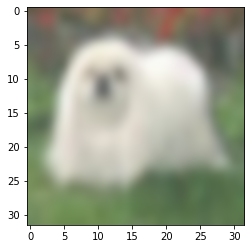

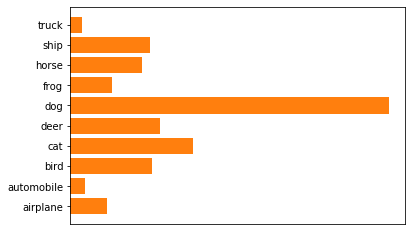

In [79]:
ck=np.random.randint(0,50000)
inp,y_inp=dt.batch_gen(size=1,ck=ck)
ans,cor,ott=validate(inp,y_inp)
print("Prediction: ",dt.names[int(ans[0])],"\nCorrect answer: ",dt.names[int(cor[0])])
plt.imshow(inp[0],interpolation='bicubic')
plt.show()
plt.barh(range(len(ott)),ott,color='#ff7f0e')
plt.yticks(range(len(ott)),dt.names)
plt.xticks([])
plt.show()

In [80]:
# Feed Forward                        #(batches, 32, 32, 3)
conv0=nn.conv2d(inp,w0,b0)
aconv0=nn.relu(conv0)
conv1=nn.conv2d(aconv0,w1,b1)
aconv1=nn.relu(conv1)
pool1,max_index1=nn.max_pool(aconv1)  #(batches, 16, 16, 128)
conv2=nn.conv2d(pool1,w2,b2)
aconv2=nn.relu(conv2)
pool2,max_index2=nn.max_pool(aconv2)  #(batches, 8, 8, 128)
conv3=nn.conv2d(pool2,w3,b3)
aconv3=nn.relu(conv3)
pool3,max_index3=nn.max_pool(aconv3)  #(batches, 4, 4, 256)
r,c,d=pool3.shape[1:]
flat=pool3.reshape(-1,r*c*d)
err3=np.empty(flat.shape)
for i,flat_layer in enumerate(flat):
    ott=ann.feed_forward(flat_layer)
    ans=ott.argmax()
    cor=y_inp[i].argmax()
    err3[i]=ann.backprop(y_inp[i])[0]
err3=err3.reshape(-1,r,c,d)            #(batches, 4, 4, 256)
# Back prop CNN
d_aconv3=nn.max_pool_back(errors=err3,inp=aconv3,max_index=max_index3)
d_conv3=d_aconv3*nn.relu_der(aconv3,conv3)
d_pool2,d_w3,d_b3=nn.conv2d_back(errors=d_conv3,inp=pool2,kernels=w3,biases=b3)
w3+=d_w3
b3+=d_b3
d_aconv2=nn.max_pool_back(errors=d_pool2,inp=aconv2,max_index=max_index2)
d_conv2=d_aconv2*nn.relu_der(aconv2,conv2)
d_pool1,d_w2,d_b2=nn.conv2d_back(errors=d_conv2,inp=pool1,kernels=w2,biases=b2)
w2+=d_w2
b2+=d_b2
d_aconv1=nn.max_pool_back(errors=d_pool1,inp=aconv1,max_index=max_index1)
d_conv1=d_aconv1*nn.relu_der(aconv1,conv1)
d_aconv0,d_w1,d_b1=nn.conv2d_back(errors=d_conv1,inp=aconv0,kernels=w1,biases=b1)
w1+=d_w1
b1+=d_b1
d_conv0=d_aconv0*nn.relu_der(aconv0,conv0)
d_inp,d_w0,d_b0=nn.conv2d_back(errors=d_conv0,inp=inp,kernels=w0,biases=b0)
w0+=d_w0
b0+=d_b0

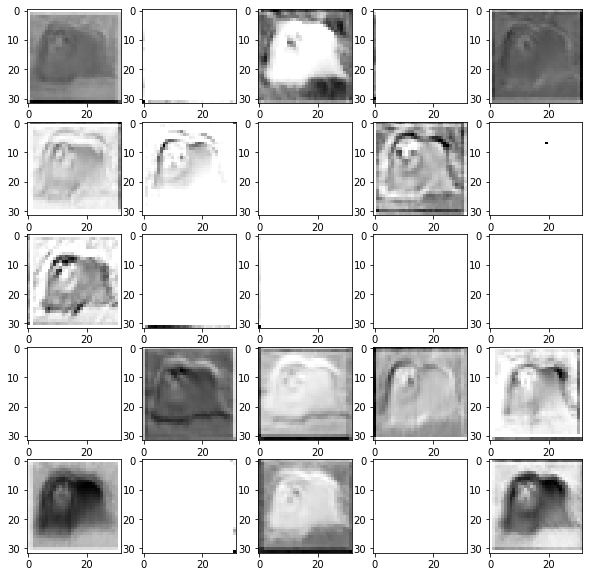

In [81]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
pme=aconv1[0].transpose(2,0,1)
for i,axi in enumerate(ax.flat):
    axi.imshow(pme[i].reshape(pme.shape[-2:]), cmap='Greys')

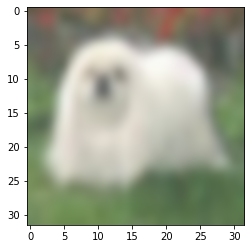

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


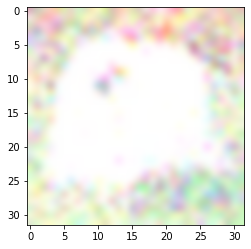

In [82]:
plt.imshow(inp[0],interpolation='bicubic')
plt.show()
plt.imshow(inp[0]+nn.normalize(d_inp)[0],interpolation='bicubic')
plt.show()

# Save/Dump Weights

In [91]:
with open('saved_w8s.dump','wb') as f:
	pickle.dump((w0,b0,w1,b1,w2,b2,w3,b3),f)
with open('ann.dump','wb') as f:
	pickle.dump(ann,f)

In [95]:
inp,y_inp=dt.batch_gen(size=40,ck=ck)

In [96]:
inp.shape

(40, 32, 32, 3)

In [106]:
%timeit conv0=nn.conv2d(inp,w0,b0)

15.5 ms ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
